# 定义公共函数

In [30]:
def train_2d(trainer):
    """Optimize the objective function of 2d variables with a customized trainer."""
    x1, x2 = -5, -2
    s_x1, s_x2 = 0, 0
    res = [(x1, x2)]
    for i in range(20):
        x1, x2, s_x1, s_x2 = trainer(x1, x2, s_x1, s_x2)
        res.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i+1, x1, x2))
    return res

def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    plt.plot(f_line, [x * x for x in f_line])
    plt.plot(res, [x * x for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('f(x)')

def show_trace_2d(f, res):
    """Show the trace of 2d variables during optimization."""
    x1, x2 = zip(*res)
    plt.plot(x1, x2, '-o', color='#ff7f0e')
    x1 = np.arange(-5.5, 1.0, 0.1)
    x2 = np.arange(min(-3.0, min(x2) - 1), max(1.0, max(x2) + 1), 0.1)
    x1, x2 = np.meshgrid(x1, x2)
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

# 优化在深度学习中的问题
## 局部最小
对于目标函数$f(x)$，如果$f(x)$在$x$上的值比在$x$邻近的其他点的值更小，那么$f(x)$可能是一个局部最小值（local minimum）。如果$f(x)$在$x$上的值是目标函数在整个定义域上的最小值，那么$f(x)$是全局最小值（global minimum）。

举个例子，给定函数

$$f(x) = x \cdot \text{cos}(\pi x), \qquad -1.0 \leq x \leq 2.0,$$

我们可以大致找出该函数的局部最小值和全局最小值的位置。需要注意的是，图中箭头所指示的只是大致位置。

Text(0, 0.5, 'f(x)')

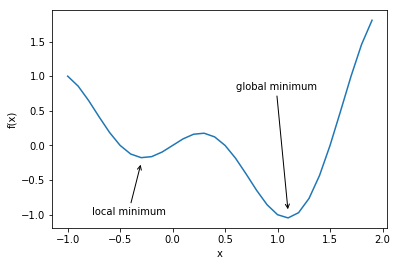

In [31]:
def f(x):
    return x * np.cos(np.pi * x)

x = np.arange(-1.0, 2.0, 0.1)
fig, = plt.plot(x, f(x))  # 逗号表示只取返回列表中的第一个元素
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)')

深度学习模型的目标函数可能有若干局部最优值。当一个优化问题的数值解在局部最优解附近时，由于目标函数有关解的梯度接近或变成零，最终迭代求得的数值解可能只令目标函数局部最小化而非全局最小化。

## 鞍点
梯度接近或变成零可能是由于当前解在局部最优解附近造成的。事实上，另一种可能性是当前解在鞍点（saddle point）附近。

举个例子，给定函数

$$f(x) = x^3,$$

我们可以找出该函数的鞍点位置。

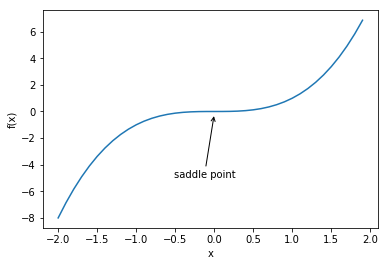

In [32]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

假设一个函数的输入为$k$维向量，输出为标量，那么它的海森矩阵（Hessian matrix）有$k$个特征值。该函数在梯度为0的位置上可能是局部最小值、局部最大值或者鞍点。

* 当函数的海森矩阵在梯度为零的位置上的特征值全为正时，该函数得到局部最小值。
* 当函数的海森矩阵在梯度为零的位置上的特征值全为负时，该函数得到局部最大值。
* 当函数的海森矩阵在梯度为零的位置上的特征值有正有负时，该函数得到鞍点。

随机矩阵理论告诉我们，对于一个大的高斯随机矩阵来说，任一特征值是正或者是负的概率都是0.5 [1]。那么，以上第一种情况的概率为 $0.5^k$。由于深度学习模型参数通常都是高维的（$k$很大），目标函数的鞍点通常比局部最小值更常见。

在深度学习中，虽然找到目标函数的全局最优解很难，但这并非必要。我们将在本章接下来的几节中逐一介绍深度学习中常用的优化算法，它们在很多实际问题中都能够训练出十分有效的深度学习模型。

# 梯度下降

使用𝑥=10作为初始值，并设𝜂=0.2。使用梯度下降对𝑥迭代10次，可见最终𝑥的值较接近最优解。

epoch 10, x: 0.06046617599999997


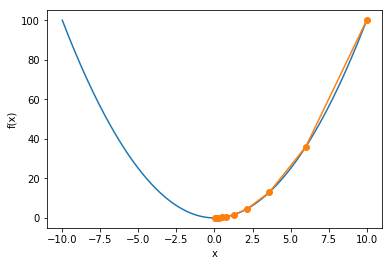

In [33]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x  # f(x) = x * x的导数为f'(x) = 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)
show_trace(res)

在了解了一维梯度下降之后，我们再考虑一种更广义的情况：目标函数的输入为向量，输出为标量。假设目标函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的输入是一个$d$维向量$\boldsymbol{x} = [x_1, x_2, \ldots, x_d]^\top$。目标函数$f(\boldsymbol{x})$有关$\boldsymbol{x}$的梯度是一个由$d$个偏导数组成的向量：

$$\nabla_{\boldsymbol{x}} f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1}, \frac{\partial f(\boldsymbol{x})}{\partial x_2}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_d}\bigg]^\top.$$


为表示简洁，我们用$\nabla f(\boldsymbol{x})$代替$\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$。梯度中每个偏导数元素$\partial f(\boldsymbol{x})/\partial x_i$代表着$f$在$\boldsymbol{x}$有关输入$x_i$的变化率。为了测量$f$沿着单位向量$\boldsymbol{u}$（即$\|\boldsymbol{u}\|=1$）方向上的变化率，在多元微积分中，我们定义$f$在$\boldsymbol{x}$上沿着$\boldsymbol{u}$方向的方向导数为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}.$$

依据方向导数性质，以上方向导数可以改写为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}.$$

方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$给出了$f$在$\boldsymbol{x}$上沿着所有可能方向的变化率。为了最小化$f$，我们希望找到$f$能被降低最快的方向。因此，我们可以通过单位向量$\boldsymbol{u}$来最小化方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$。

由于$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \|\nabla f(\boldsymbol{x})\| \cdot \|\boldsymbol{u}\|  \cdot \text{cos} (\theta) = \|\nabla f(\boldsymbol{x})\|  \cdot \text{cos} (\theta)$，
其中$\theta$为梯度$\nabla f(\boldsymbol{x})$和单位向量$\boldsymbol{u}$之间的夹角，当$\theta = \pi$时，$\text{cos}(\theta)$取得最小值$-1$。因此，当$\boldsymbol{u}$在梯度方向$\nabla f(\boldsymbol{x})$的相反方向时，方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数$f$的值：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f(\boldsymbol{x}).$$

同样，其中$\eta$（取正数）称作学习率。


# 动量法（Momentum） 

## 梯度下降的问题

让我们考虑一个输入和输出分别为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和标量的目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$。这里将$x_1^2$系数从$1$减小到了$0.1$。下面实现基于这个目标函数的梯度下降，并演示使用学习率为$0.4$时自变量的迭代轨迹。

In [3]:
def train_2d(trainer):
    """Optimize the objective function of 2d variables with a customized trainer."""
    x1, x2 = -5, -2
    s_x1, s_x2 = 0, 0
    res = [(x1, x2)]
    for i in range(20):
        x1, x2, s_x1, s_x2 = trainer(x1, x2, s_x1, s_x2)
        res.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i+1, x1, x2))
    return res

def show_trace_2d(f, res):
    """Show the trace of 2d variables during optimization."""
    x1, x2 = zip(*res)
    plt.plot(x1, x2, '-o', color='#ff7f0e')
    x1 = np.arange(-5.5, 1.0, 0.1)
    x2 = np.arange(min(-3.0, min(x2) - 1), max(1.0, max(x2) + 1), 0.1)
    x1, x2 = np.meshgrid(x1, x2)
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

epoch 20, x1 -0.943467, x2 -0.000073


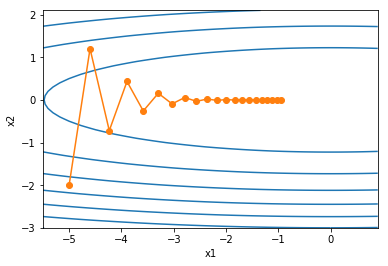

In [4]:
%matplotlib inline
import numpy as np

from matplotlib import pyplot as plt

eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

可以看到，同一位置上，目标函数在竖直方向（𝑥2轴方向）比在水平方向（𝑥1轴方向）的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。那么，我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

下面我们试着将学习率调得稍大一点，此时自变量在竖直方向不断越过最优解并逐渐发散。

epoch 20, x1 -0.387814, x2 -1673.365109


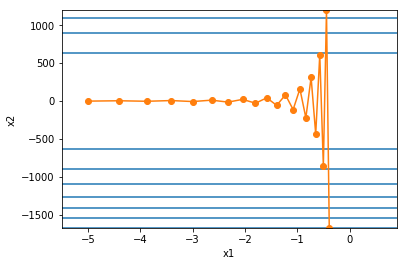

In [5]:
eta = 0.6
show_trace_2d(f_2d, train_2d(gd_2d))

## 动量法
动量法的提出是为了解决梯度下降的上述问题。设时间步$t$的自变量为$\boldsymbol{x}_t$，学习率为$\eta_t$。
在时间步$0$，动量法创建速度变量$\boldsymbol{v}_0$，并将其元素初始化成0。在时间步$t>0$，动量法对每次迭代的步骤做如下修改：

$$
\begin{aligned}
\boldsymbol{v}_t &\leftarrow \gamma \boldsymbol{v}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t,
\end{aligned}
$$

其中，动量超参数$\gamma$满足$0 \leq \gamma < 1$。当$\gamma=0$时，动量法等价于小批量随机梯度下降。

在解释动量法的数学原理前，让我们先从实验中观察梯度下降在使用动量法后的迭代轨迹。

epoch 20, x1 -0.062843, x2 0.001202


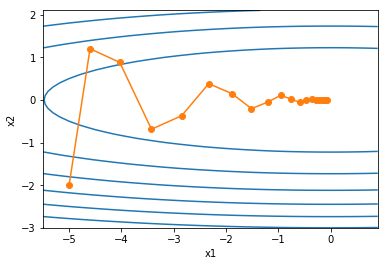

In [6]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

可以看到使用较小的学习率$\eta=0.4$和动量超参数$\gamma=0.5$时，动量法在竖直方向上的移动更加平滑，且在水平方向上更快逼近最优解。下面使用较大的学习率$\eta=0.6$，此时自变量也不再发散。

epoch 20, x1 0.007188, x2 0.002553


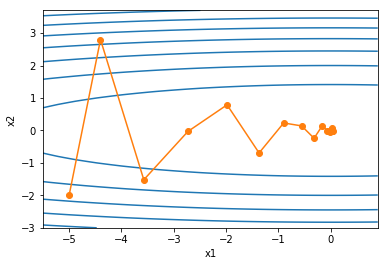

In [8]:
eta = 0.6
show_trace_2d(f_2d, train_2d(momentum_2d))

## 指数加权移动平均

为了从数学上理解动量法，让我们先解释一下指数加权移动平均（exponentially weighted moving average）。给定超参数$0 \leq \gamma < 1$，当前时间步$t$的变量$y_t$是上一时间步$t-1$的变量$y_{t-1}$和当前时间步另一变量$x_t$的线性组合：

$$y_t = \gamma y_{t-1} + (1-\gamma) x_t.$$

我们可以对$y_t$展开：

$$
\begin{aligned}
y_t  &= (1-\gamma) x_t + \gamma y_{t-1}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + \gamma^2y_{t-2}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \gamma^3y_{t-3}\\
         &\ldots
\end{aligned}
$$

令$n = 1/(1-\gamma)$，那么 $\left(1-1/n\right)^n = \gamma^{1/(1-\gamma)}$。

因为

$$ \lim_{n \rightarrow \infty}  \left(1-\frac{1}{n}\right)^n = \exp(-1) \approx 0.3679,$$

所以当$\gamma \rightarrow 1$时，$\gamma^{1/(1-\gamma)}=\exp(-1)$，如$0.95^{20} \approx \exp(-1)$。如果把$\exp(-1)$当作一个比较小的数，我们可以在近似中忽略所有含$\gamma^{1/(1-\gamma)}$和比$\gamma^{1/(1-\gamma)}$更高阶的系数的项。例如，当$\gamma=0.95$时，

$$y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}.$$

因此，在实际中，我们常常将$y_t$看作是对最近$1/(1-\gamma)$个时间步的$x_t$值的加权平均。例如，当$\gamma = 0.95$时，$y_t$可以被看作对最近20个时间步的$x_t$值的加权平均；当$\gamma = 0.9$时，$y_t$可以看作是对最近10个时间步的$x_t$值的加权平均。而且，离当前时间步$t$越近的$x_t$值获得的权重越大（越接近1）。


### 由指数加权移动平均理解动量法

现在，我们对动量法的速度变量做变形：

$$\boldsymbol{v}_t \leftarrow \gamma \boldsymbol{v}_{t-1} + (1 - \gamma) \left(\frac{\eta_t}{1 - \gamma} \boldsymbol{g}_t\right). $$

由指数加权移动平均的形式可得，速度变量$\boldsymbol{v}_t$实际上对序列$\{\eta_{t-i}\boldsymbol{g}_{t-i} /(1-\gamma)\}$做了指数加权移动平均。换句话说，相比于批量随机梯度下降，动量法在每个时间步的自变量更新量近似于将前者对应的最近$1/(1-\gamma)$个时间步的更新量做了指数加权移动平均后再除以$1-\gamma$。所以，在动量法中，自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。

# AdaGrad¶

AdaGrad算法会使用一个小批量随机梯度$\boldsymbol{g}_t$按元素平方的累加变量$\boldsymbol{s}_t$。在时间步0，AdaGrad将$\boldsymbol{s}_0$中每个元素初始化为0。在时间步$t$，首先将小批量随机梯度$\boldsymbol{g}_t$按元素平方后累加到变量$\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$

其中$\odot$是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。


### 特点
需要强调的是，小批量随机梯度按元素平方的累加变量$\boldsymbol{s}_t$出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于$\boldsymbol{s}_t$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

下面我们仍然以目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$为例观察AdaGrad算法对自变量的迭代轨迹。我们实现AdaGrad算法并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

epoch 20, x1 -2.382563, x2 -0.158591


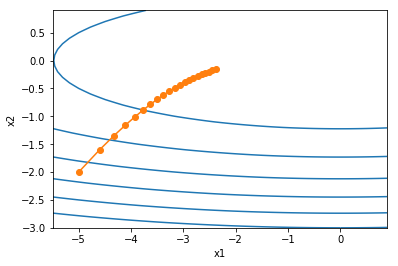

In [14]:
import math

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

下面将学习率增大到2。可以看到自变量更为迅速地逼近了最优解。

epoch 20, x1 -0.002295, x2 -0.000000


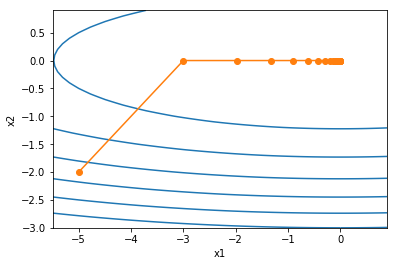

In [11]:
eta = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

# RMSProp 算法
我们在“AdaGrad算法”一节中提到，因为调整学习率时分母上的变量$\boldsymbol{s}_t$一直在累加按元素平方的小批量随机梯度，所以目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。
可能导致两个问题
- 学习率逐步减小到0
- 当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

为了解决这一问题，RMSProp算法对AdaGrad算法做了一点小小的修改。

## 算法
我们在[“动量法”]一节里介绍过指数加权移动平均。不同于AdaGrad算法里状态变量$\boldsymbol{s}_t$是截至时间步$t$所有小批量随机梯度$\boldsymbol{g}_t$按元素平方和，RMSProp算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数$0 \leq \gamma < 1$，RMSProp算法在时间步$t>0$计算

$$\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

和AdaGrad算法一样，RMSProp算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t, $$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。因为RMSProp算法的状态变量$\boldsymbol{s}_t$是对平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的指数加权移动平均，所以可以看作是最近$1/(1-\gamma)$个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）。

照例，让我们先观察RMSProp算法对目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$中自变量的迭代轨迹。与AdaGrad使用相同的学习率（0.4），自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp算法可以更快逼近最优解。

epoch 20, x1 -0.010599, x2 0.000000


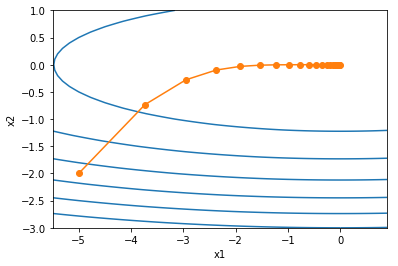

In [15]:
import math

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))